(getting-started:tutorial-built-in-functions)=
# Tutorial: Create Built-in Test Functions

UQTestFuns includes a wide range of test functions from the uncertainty
quantification community; these functions are referred to
as the _built-in test functions_.
This tutorial provides you with an overview of the package;
you'll learn about the built-in test functions, their common interfaces,
as well as their important properties and methods.

By the end of this tutorial, you'll be able to create any test function
available in UQTestFuns and access its basic but important functionalities.

UQTestFuns is designed to work with minimal dependency within the numerical
Python ecosystem.
At the very least, UQTestFuns requires NumPy and SciPy to work.
It might be a good idea to import NumPy alongside UQTestFuns:

In [1]:
import numpy as np
import uqtestfuns as uqtf

## Listing available test functions

To list all the test functions currently available:

In [2]:
uqtf.list_functions()

 No.            Constructor            Dimension                Application                Description
-----  -----------------------------  -----------  --------------------------------------  ----------------------------------------------------------------------------
  1              Ackley()                  M             optimization, metamodeling        Optimization test function from Ackley (1987)
  2           Alemazkoor20D()             20                    metamodeling               High-dimensional low-degree polynomial from Alemazkoor & Meidani (2018)
  3           Alemazkoor2D()               2                    metamodeling               Low-dimensional high-degree polynomial from Alemazkoor & Meidani (2018)
  4             Borehole()                 8             metamodeling, sensitivity         Borehole function from Harper and Gupta (1983)
  5           Bratley1992a()               M              integration, sensitivity         Integration test function #1 from Bra

This function produces a list of test functions,
their respective constructor, spatial dimension, typical applications,
as well as a short description.

## A Callable instance

Take, for instance, the {ref}`borehole <test-functions:borehole>` function
{cite}`Harper1983`, an eight-dimensional test function typically used
in the context of metamodeling and sensitivity analysis.
To instantiate a borehole test function, call the constructor as follows:

In [3]:
my_testfun = uqtf.Borehole()

To verify whether the instance has been created,
print it to get some basic information on the terminal:

In [4]:
print(my_testfun)

Name              : Borehole
Spatial dimension : 8
Description       : Borehole function from Harper and Gupta (1983)


```{margin}
Think of a `Callable` as a regular function;
it takes some inputs, evaluates them, and produces some outputs.
In otherwords, you _call_ it with arguments.
```

The resulting object is a `Callable`.
The instance can be evaluated with a set of input values.
For example, the eight-dimensional borehole function can be evaluated
at a single point (1-by-8 array):

In [5]:
xx = np.array([
  [
    1.04803586e-01, 2.54527756e+03, 9.44572869e+04, 9.94988176e+02,
    6.31793993e+01, 7.63308791e+02, 1.57530252e+03, 1.00591588e+04
  ]
])
my_testfun(xx)

array([50.7642835])

```{note}
Calling the function on a set of input values automatically
verifies the correctness of the input (its dimensionality and bounds).
Moreover, the test function accepts a vectorized input
(that is, an $N$-by-$M$ array where $N$ and $M$ are the number of points
and dimensions, respectively)
```

## Probabilistic input

In general, the results of uncertainty quantification (UQ) analyses
depend on the specified probabilistic input.
When a test function appears in the literature,
a specification for the probabilistic input is usually provided.
In UQTestFuns, a probabilistic input model is an integral part
of each test function.

For instance, the borehole function has a probabilistic input model
that consists of eight independent random variables.
This input model is stored inside the `prob_input` property
of the test function instance.
Print it to the terminal to see the full specification:

In [6]:
print(my_testfun.prob_input)

Name         : Borehole-Harper-1983
Spatial Dim. : 8
Description  : Probabilistic input model of the Borehole model from Harper and Gupta (1983).
Marginals    :

  No.   Name    Distribution        Parameters                          Description
-----  ------  --------------  ---------------------  -----------------------------------------------
    1    rw        normal      [0.1       0.0161812]            radius of the borehole [m]
    2    r       lognormal        [7.71   1.0056]                 radius of influence [m]
    3    Tu       uniform        [ 63070. 115600.]      transmissivity of upper aquifer [m^2/year]
    4    Hu       uniform          [ 990. 1100.]         potentiometric head of upper aquifer [m]
    5    Tl       uniform          [ 63.1 116. ]        transmissivity of lower aquifer [m^2/year]
    6    Hl       uniform           [700. 820.]          potentiometric head of lower aquifer [m]
    7    L        uniform          [1120. 1680.]                length of the

```{note}
_Copulas_ models the statistical dependence structure
between the component (univariate) marginals.
If the marginals are independent, then the copulas value is `None`.
Currently, UQTestFuns does not support dependent probability inputs.
```

From the underlying probabilistic input model,
a set of input values can be randomly generated.
This is often useful for verification and validation purposes.
For instance, to generate $10'000$ sample points:

In [7]:
xx_sample = my_testfun.prob_input.get_sample(10000)
yy_sample = my_testfun(xx_sample)

The histogram of the output values can be created as follows:

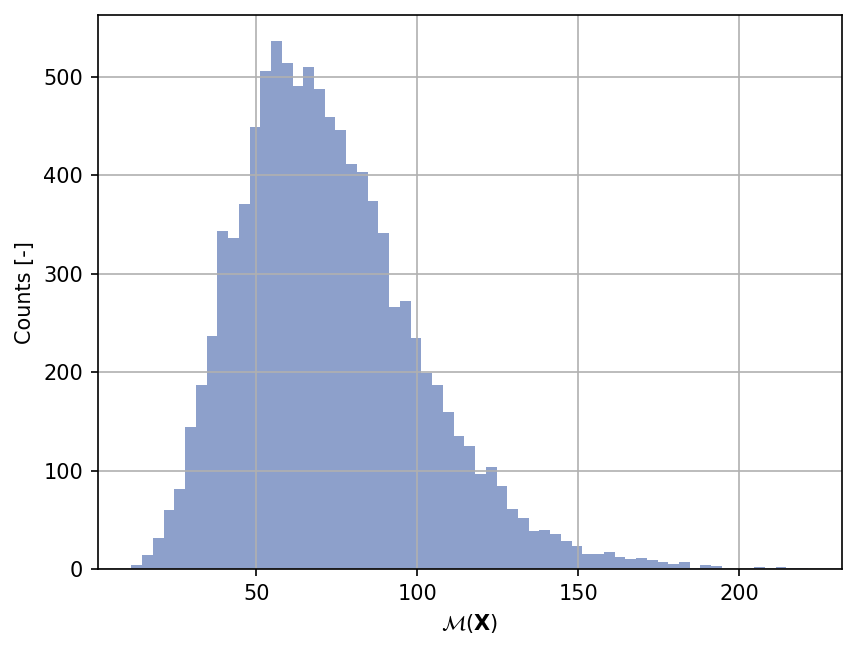

In [8]:
import matplotlib.pyplot as plt

plt.hist(yy_sample, bins="auto", color="#8da0cb")
plt.grid()
plt.xlabel("$\mathcal{M}(\mathbf{X})$")
plt.ylabel("Counts [-]")
plt.gcf().set_dpi(150);

```{note}
An `ProbInput` instance has a method called `reset_rng()`;
You can call this method to create a new underlying RNG
perhaps with a seed number.
In that case, the seed number is optional; if not specified,
the system entropy is used to initialized
the [NumPy default random generator](https://numpy.org/doc/stable/reference/random/generator.html#numpy.random.default_rng).

In UQTestFuns, each instance of probabilistic input model carries
its own pseudo-random number generator (RNG)
to avoid using the global NumPy random RNG.
See this [blog post](https://albertcthomas.github.io/good-practices-random-number-generators/)
regarding some good practices on using NumPy RNG.
```

## Transformation to the function domain

Some UQ methods often produce sample points in a hypercube domain
(for example, $[0, 1]^M$ or $[-1, 1]^M$ where $M$ is the number of spatial dimension)
at which the function should be evaluated.
This hypercube domain may differ from the test function's domain.
Before the test function can be evaluated,
those values must be first transformed to the function domain.

```{margin}
The transformation is done via an isoprobabilistic transformation.
```

UQTestFuns provides a convenient function to transform sample points
in one domain to the function domain.
For instance, suppose we have a sample of size $5$ in $[-1, 1]^8$
for the borehole function:

In [9]:
rng_1 = np.random.default_rng(42)
xx_sample_dom_1 = rng_1.uniform(low=-1, high=1, size=(5, 8))
xx_sample_dom_1

array([[ 0.5479121 , -0.12224312,  0.71719584,  0.39473606, -0.8116453 ,
         0.9512447 ,  0.5222794 ,  0.57212861],
       [-0.74377273, -0.09922812, -0.25840395,  0.85352998,  0.28773024,
         0.64552323, -0.1131716 , -0.54552256],
       [ 0.10916957, -0.87236549,  0.65526234,  0.2633288 ,  0.51617548,
        -0.29094806,  0.94139605,  0.78624224],
       [ 0.55676699, -0.61072258, -0.06655799, -0.91239247, -0.69142102,
         0.36609791,  0.48952431,  0.93501946],
       [-0.34834928, -0.25908059, -0.06088838, -0.62105728, -0.74015699,
        -0.04859015, -0.5461813 ,  0.33962799]])

We can transform this set of values to the domain of the function
via the `transform_sample()` method:

In [10]:
xx_sample_trans_1 = my_testfun.transform_sample(xx_sample_dom_1)
xx_sample_trans_1

array([[1.12167271e-01, 1.91089168e+03, 1.08172149e+05, 1.06671048e+03,
        6.80819817e+01, 8.17074682e+02, 1.54623823e+03, 1.16042925e+04],
       [8.16286191e-02, 1.96768976e+03, 8.25480202e+04, 1.09194415e+03,
        9.71604649e+01, 7.98731394e+02, 1.36831195e+03, 1.04531118e+04],
       [1.02220926e-01, 4.82013357e+02, 1.06545465e+05, 1.05948308e+03,
        1.03202841e+02, 7.42543116e+02, 1.66359089e+03, 1.18248295e+04],
       [1.12406858e-01, 9.38469433e+02, 8.75868543e+04, 9.94818414e+02,
        7.12619141e+01, 7.81965874e+02, 1.53706681e+03, 1.19780700e+04],
       [9.26946708e-02, 1.59960562e+03, 8.77357668e+04, 1.01084185e+03,
        6.99728476e+01, 7.57084591e+02, 1.24706924e+03, 1.13648168e+04]])

By default, the method assumes the uniform domain of the passed values
is in $[-1, 1]^M$.
It is possible to transform values defined in another uniform domain.
For example, the sample values in $[0, 1]^8$ (a unit hypercube):

In [11]:
rng_2 = np.random.default_rng(42)
xx_sample_dom_2 = rng_2.random((5, 8))
xx_sample_dom_2

array([[0.77395605, 0.43887844, 0.85859792, 0.69736803, 0.09417735,
        0.97562235, 0.7611397 , 0.78606431],
       [0.12811363, 0.45038594, 0.37079802, 0.92676499, 0.64386512,
        0.82276161, 0.4434142 , 0.22723872],
       [0.55458479, 0.06381726, 0.82763117, 0.6316644 , 0.75808774,
        0.35452597, 0.97069802, 0.89312112],
       [0.7783835 , 0.19463871, 0.466721  , 0.04380377, 0.15428949,
        0.68304895, 0.74476216, 0.96750973],
       [0.32582536, 0.37045971, 0.46955581, 0.18947136, 0.12992151,
        0.47570493, 0.22690935, 0.66981399]])

can be transformed to the domain of the borehole function as follows:

In [12]:
xx_sample_trans_2 = my_testfun.transform_sample(
    xx_sample_dom_2, min_value=0.0, max_value=1.0
)
xx_sample_trans_2

array([[1.12167271e-01, 1.91089168e+03, 1.08172149e+05, 1.06671048e+03,
        6.80819817e+01, 8.17074682e+02, 1.54623823e+03, 1.16042925e+04],
       [8.16286191e-02, 1.96768976e+03, 8.25480202e+04, 1.09194415e+03,
        9.71604649e+01, 7.98731394e+02, 1.36831195e+03, 1.04531118e+04],
       [1.02220926e-01, 4.82013357e+02, 1.06545465e+05, 1.05948308e+03,
        1.03202841e+02, 7.42543116e+02, 1.66359089e+03, 1.18248295e+04],
       [1.12406858e-01, 9.38469433e+02, 8.75868543e+04, 9.94818414e+02,
        7.12619141e+01, 7.81965874e+02, 1.53706681e+03, 1.19780700e+04],
       [9.26946708e-02, 1.59960562e+03, 8.77357668e+04, 1.01084185e+03,
        6.99728476e+01, 7.57084591e+02, 1.24706924e+03, 1.13648168e+04]])

Note that for a given sample, the bounds of the hypercube domain must be
the same in all dimensions.

The two transformed values above should be the same since
we use two instances of the default RNG with the same seed
to generate the random sample.

In [13]:
assert np.allclose(xx_sample_trans_1, xx_sample_trans_2)
assert np.allclose(my_testfun(xx_sample_trans_1), my_testfun(xx_sample_trans_2))

## Test functions with parameters

```{margin}
Parameters of a test function can be anything.
```

Some test functions are _parameterized_;
this means that to fully specify the function,
an additional set of values must be specified.
In principle, these parameter values can be anything:
numerical values, flags, selection using strings, etc.

For instance, consider the {ref}`Ishigami <test-functions:ishigami>` function
{cite}`Ishigami1991` defined as follows:

$$
\mathcal{M}(\boldsymbol{x}) = \sin{(x_1)} + a \sin^2{(x_2)} + b x_3^4 \sin{(x_1)}
$$

where $a$ and $b$ are the so-called parameters of the function.
Before the function can be evaluated,
these parameters must be assigned to some values.
The default Ishigami function in UQTestFuns has these values given
and stored in the `parameters` property:

In [14]:
my_testfun = uqtf.Ishigami()
my_testfun.parameters

(7, 0.05)

To assign different parameter values, override the property values of the instance.
For example:

In [15]:
my_testfun.parameters = (7, 0.35)
my_testfun.parameters

(7, 0.35)

Note that once set, the parameter values are kept constant
during the evaluation of the function on a set of input values

Different parameter values usually change the overall behavior of the function.
In the case of the Ishigami function,
different parameter values alter the total variance of the output
as illustrated in the figure below.

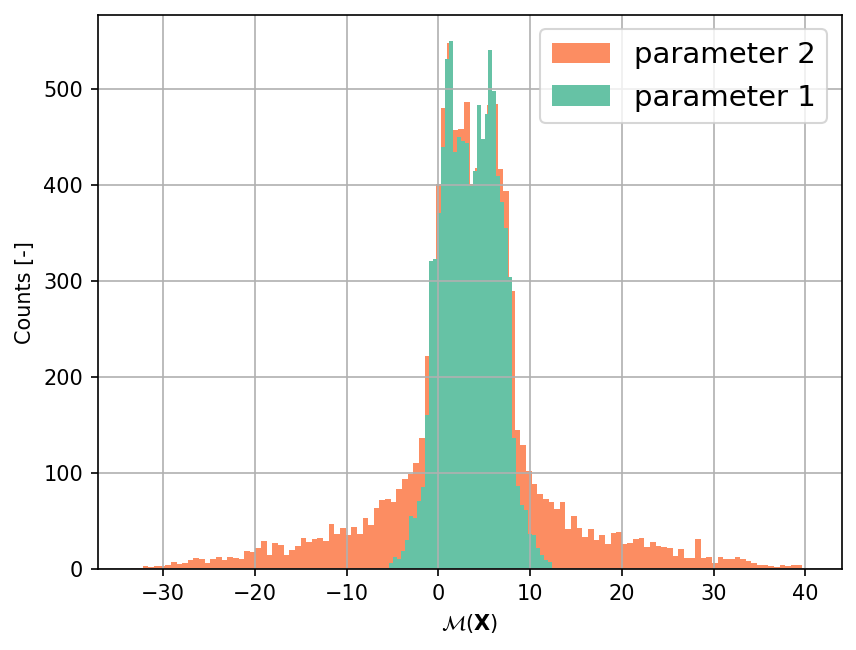

In [16]:
xx_sample = my_testfun.prob_input.get_sample(10000)
my_testfun.parameters = (7, 0.05)
yy_param_1 = my_testfun(xx_sample)
my_testfun.parameters = (7, 0.35)
yy_param_2 = my_testfun(xx_sample)

plt.hist(yy_param_2, bins="auto", color="#fc8d62", label="parameter 2")
plt.hist(yy_param_1, bins="auto", color="#66c2a5", label="parameter 1")
plt.grid()
plt.xlabel("$\mathcal{M}(\mathbf{X})$")
plt.ylabel("Counts [-]")
plt.legend(fontsize=14)
plt.gcf().set_dpi(150);

## Test functions with variable dimension

```{margin}
Spatial dimension must be a positive integer.
```

Some test functions support a _variable dimension_, meaning that an instance
of a test function can be constructed for any number (positive integer, please) 
of spatial dimension.

Consider, for instance, the {ref}`Sobol'-G <test-functions:sobol-g>` function
{cite}`Saltelli1995`,
a test function whose dimension can be varied
and a popular choice in the context of sensitivity analysis.
It is defined as follows:

$$
\mathcal{M}(\boldsymbol{x}) = \prod_{m = 1}^M \frac{\lvert 4 x_m - 2 \rvert + a_m}{1 + a_m}
$$
where $\boldsymbol{x} = \{ x_1, \ldots, x_M \}$ is the $M$-dimensional vector
of input variables,
and $\boldsymbol{a} = \{ a_1, \ldots, a_M \}$ are parameters of the function.

To create a six-dimensional Sobol'-G function,
use the parameter `spatial_dimension` to specify the desired dimensionality:

In [17]:
my_testfun = uqtf.SobolG(spatial_dimension=6)

Verify that the function is indeed a six-dimension one:

In [18]:
print(my_testfun)

Name              : SobolG
Spatial dimension : 6
Description       : Sobol'-G function from Saltelli and Sobol' (1995)


and:

In [19]:
print(my_testfun.prob_input)

Name         : Sobol-G-Saltelli1995
Spatial Dim. : 6
Description  : Probabilistic input model for the Sobol'-G function from Saltelli and Sobol' (1995)
Marginals    :

  No.   Name    Distribution    Parameters    Description
-----  ------  --------------  ------------  -------------
    1    X1       uniform        [0. 1.]         None
    2    X2       uniform        [0. 1.]         None
    3    X3       uniform        [0. 1.]         None
    4    X4       uniform        [0. 1.]         None
    5    X5       uniform        [0. 1.]         None
    6    X6       uniform        [0. 1.]         None

Copulas      : None


## References

```{bibliography}
:style: unsrtalpha
:filter: docname in docnames
```